In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from engine import *
from nn import *
from extension import *

import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def bptt_loss(yb_seq, predictions_seq):
    seq_len = len(yb_seq)
    losses = []

    # Compute the loss for each step in the sequence
    for t in range(seq_len):
        yb_t = yb_seq[t]
        predictions_t = predictions_seq[t]  # Extract the Value
        loss_t = (yb_t - predictions_t)**2
        losses.append(loss_t)

    # Average the losses over the sequence length
    total_loss = sum(losses) * (1.0 / seq_len)
    return total_loss

def bptt_mean_relative_error(yb_seq, predictions_seq, epsilon=1e-6):
    seq_len = len(yb_seq)
    errors = []

    # Compute the relative error for each step in the sequence
    for t in range(seq_len):
        yb_t = yb_seq[t]
        predictions_t = predictions_seq[t]  # Extract the Value from the tuple
        error_t = abs(yb_t.data - predictions_t.data) / abs(yb_t.data) + epsilon
        errors.append(error_t)

    # Compute the mean relative error over the sequence length
    mean_relative_error = sum(errors) / seq_len
    return mean_relative_error

def plot_loss_and_accuracy(steps, losses, accuracies, ignore_first_n=0):
    sns.set(style="ticks", context="paper")
    
    # Slice the lists to ignore the first n steps
    steps = steps[ignore_first_n:]
    losses = losses[ignore_first_n:]
    accuracies = accuracies[ignore_first_n:]

    fig, ax1 = plt.subplots()

    # Plot the loss on the left y-axis
    sns.lineplot(x=steps, y=losses, ax=ax1, label="Loss", color="blue", linewidth=1)
    ax1.set_xlabel("Steps")
    ax1.set_ylabel("Loss", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")

    # Create a second y-axis for the accuracy
    ax2 = ax1.twinx()

    # Plot the accuracy on the right y-axis
    sns.lineplot(x=steps, y=accuracies, ax=ax2, label="Accuracy", color="red", linewidth=1)
    ax2.set_ylabel("Accuracy", color="red")
    ax2.tick_params(axis="y", labelcolor="red")

    # Remove the top and right spines
    sns.despine(ax=ax1, right=True, top=True)
    sns.despine(ax=ax2, left=True, top=True)

    # Show the plot
    plt.title("Loss and Accuracy Evolution")
    plt.show()

def training(rnn, 
            X_train, y_train, 
            X_val, y_val, 
            epochs=100, clip_value=1.0,
            learning_rate_init=0.01, lr_decay=0.009, lr_decay_steps=None,
            store_every=10):
    
    
    # Initialize hidden state
    h_prev = [[Value(value.data)] for value in X_train[0] for _ in range(len(rnn.layers))]

    # Optimizaiton parameters
    if lr_decay_steps is None:
        lr_decay_steps = epochs

    steps, losses, accuracies = [], [], []

    # Initialize hidden states for validation
    h_prev_val = [[Value(value.data)] for value in X_val[0] for _ in range(len(rnn.layers))]

    # Training loop
    for k in range(epochs):

        # forward
        train_output, _ = rnn(X_train[1:], h_prev)

        # compute loss
        train_loss = bptt_loss([item for sublist in y_train[1:] for item in sublist], [item for sublist in train_output for item in sublist])

        # compute validation accuracy
        val_output, _ = rnn(X_val[1:], h_prev_val)
        val_accuracy = 1 - bptt_mean_relative_error([item for sublist in y_val[1:] for item in sublist], [item for sublist in val_output for item in sublist])

        # backward
        rnn.zero_grad()
        train_loss.backward()

        # gradient clipping
        for p in rnn.parameters():
            grad_norm = p.grad ** 2
            if grad_norm > clip_value ** 2:
                p.grad *= (clip_value / math.sqrt(grad_norm))
        
        # learning rate
        learning_rate = learning_rate_init - lr_decay*k/lr_decay_steps
        for p in rnn.parameters():
            p.data -= learning_rate * p.grad
        
        # store data every 10 steps
        if k % store_every == 0:
            steps.append(k)
            losses.append(train_loss.data)
            accuracies.append(val_accuracy)

    # Final evaluation
    steps.append(k)
    losses.append(train_loss.data)
    accuracies.append(val_accuracy)

    return rnn, steps, losses, accuracies

Loss: 0.0026, Accuracy: 0.8963


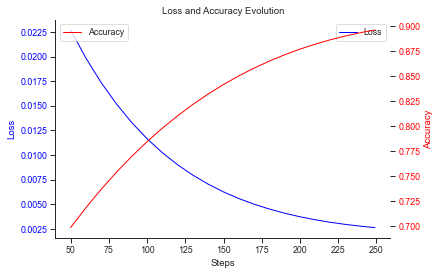

In [4]:
# Create a single-layer RNN with 1 input and 1 output
rnn = RNN(1, [1])
# rnn = RNN(1, [1, 1])

# Data sequence: [0, 1, 2, 3, 4, ...]
input_sequence = [[Value(i)] for i in np.arange(0.0, 1.0, 0.05)]
target_sequence = [[Value(i)] for i in np.arange(0.05, 1.05, 0.05)]

# Prepare a val input sequence
val_input_sequence = [[Value(i)] for i in np.arange(1.05, 1.50, 0.05)]
val_target_sequence = [[Value(i)] for i in np.arange(1.10, 1.55, 0.05)]

# Train the RNN
rnn, steps, losses, accuracies = training(rnn, input_sequence, target_sequence, val_input_sequence, val_target_sequence, 
                                        epochs=250, clip_value=1.0, learning_rate_init=0.05, lr_decay=0.04, lr_decay_steps=None, store_every=10)

print(f"Loss: {round(losses[-1], 4)}, Accuracy: {round(accuracies[-1], 4)}")
plot_loss_and_accuracy(steps, losses, accuracies, ignore_first_n=5)

In [5]:
def testing(rnn, X_test, y_test):
    # Initialize hidden state
    h_prev = [[Value(value.data)] for value in X_test[0] for _ in range(len(rnn.layers))]

    # forward
    test_output, _ = rnn(X_test, h_prev)

    # compute loss
    test_loss = bptt_loss([item for sublist in y_test for item in sublist], [item for sublist in test_output for item in sublist])

    # compute validation accuracy
    test_accuracy = 1 - bptt_mean_relative_error([item for sublist in y_test for item in sublist], [item for sublist in test_output for item in sublist])

    return test_loss, test_accuracy

In [6]:
# Prepare a val input sequence
test_input_sequence = [[Value(i)] for i in np.arange(2.05, 2.50, 0.05)]
test_output_sequence = [[Value(i)] for i in np.arange(2.10, 2.55, 0.05)]

testing(rnn, test_input_sequence, test_output_sequence)

(Value(data=0.10522331629818109, grad=0), 0.8606450543724415)

More complex sequences

In [30]:
# Generate a training sequence
# train_x = np.arange(0.0, 100.0, 1.0)
# train_y = np.sin(train_x) + np.random.normal(0, 0.1, len(train_x))

# input_sequence_train = [[Value(i)] for i in train_y]
# target_sequence_train = [[Value(i)] for i in train_y[1:]]
n_train = 250
input_sequence = [[Value(math.sin(i * 0.1) + np.random.normal(0, 0.01))] for i in range(n_train)]
target_sequence = [[Value(math.sin((i + 1) * 0.1) + np.random.normal(0, 0.01))] for i in range(n_train)]

# Generate a validation sequence
# val_x = np.arange(100.0, 125.0, 1.0)
# val_y = np.sin(val_x) + np.random.normal(0, 0.1, len(val_x))
n_val = 50
val_input_sequence = [[Value(math.sin(i * 0.1) + np.random.normal(0, 0.01))] for i in range(n_train, n_train + n_val)]
val_target_sequence = [[Value(math.sin((i + 1) * 0.1) + np.random.normal(0, 0.01))] for i in range(n_train, n_train + n_val)]

# n_train = 100
# input_sequence = [[Value(math.sin(i * 0.1))] for i in range(n_train)]
# target_sequence = [[Value(math.sin((i + 1) * 0.1))] for i in range(n_train)]

# n_val = 20
# val_input_sequence = [[Value(math.sin(i * 0.1))] for i in range(n_train, n_train + n_val)]
# val_target_sequence = [[Value(math.sin((i + 1) * 0.1))] for i in range(n_train, n_train + n_val)]

# input_sequence_val = [[Value(i)] for i in val_y]
# target_sequence_val = [[Value(i)] for i in val_y[1:]]

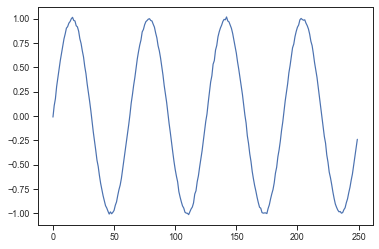

In [31]:
plt.plot(range(n_train), [val[0].data for val in input_sequence], label="Training")

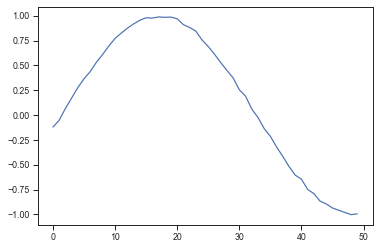

In [32]:
plt.plot(range(n_val), [val[0].data for val in val_input_sequence], label="Training")

Loss: 0.0056, Accuracy: 0.7344


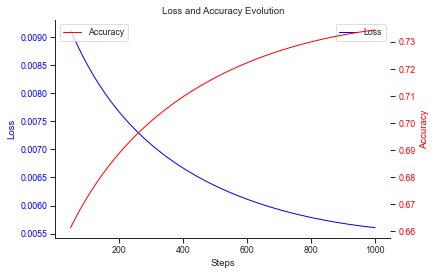

In [37]:
rnn = RNN(1, [1])
# rnn, steps, losses, accuracies = training(rnn, input_sequence_train, target_sequence_train, input_sequence_val, target_sequence_val,
#                                     epochs=500, clip_value=1.0, learning_rate_init=0.1, lr_decay=0.999, lr_decay_steps=None, store_every=10)

# Train the RNN
rnn, steps, losses, accuracies = training(rnn, input_sequence, target_sequence, val_input_sequence, val_target_sequence, 
                                        epochs=1000, clip_value=1.0, learning_rate_init=0.05, lr_decay=0.04, lr_decay_steps=None, store_every=10)

print(f"Loss: {round(losses[-1], 4)}, Accuracy: {round(accuracies[-1], 4)}")
plot_loss_and_accuracy(steps, losses, accuracies, ignore_first_n=5)

In [40]:
# Generate a test sequence
# test_x = np.arange(100.0, 2.5, 0.05)
# test_y = np.sin(test_x) + np.random.normal(0, 0.1, len(test_x))

# input_sequence_test = [[Value(i)] for i in test_y]
# target_sequence_test = [[Value(i)] for i in test_y[1:]]

n_test = 75
test_input_sequence = [[Value(math.sin(i * 0.1) + np.random.normal(0, 0.01))] for i in range(n_train + n_val, n_train + n_val + n_test)]
test_target_sequence = [[Value(math.sin((i + 1) * 0.1) + np.random.normal(0, 0.01))] for i in range(n_train + n_val, n_train + n_val + n_test)]


testing(rnn, test_input_sequence, test_target_sequence)

(Value(data=0.005120447750006083, grad=0), 0.7438383637639416)

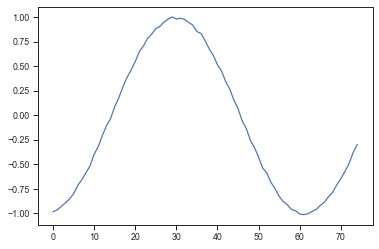

In [42]:
plt.plot(range(n_test), [val[0].data for val in test_input_sequence], label="Training")